In [1]:
from pathlib import Path
import sys
import os
import pandas as pd
import numpy as np
import ast

In [7]:
DATA_DIR = Path("../data")
default_path = DATA_DIR / "data.csv"
war_related_path = DATA_DIR / "data_war_related.csv"
war_related_ner_path = DATA_DIR / "data_war_related_ner.csv"

# 1. Load the data --> data.csv, data_war_related.csv, data_war_related_ner.csv
# 2. Handle missing values
# 3. Handle DateTime columns
# 6. Save the cleaned data to a new CSV file

class Extract:
    def __init__(self, default_path, war_related_path, war_related_ner_path):
        self.default_path = default_path
        self.war_related_path = war_related_path
        self.war_related_ner_path = war_related_ner_path
        

    def load_data(self):
        """Load the data from CSV files."""
        data = pd.read_csv(self.default_path, index_col=0)
        war_related_data = pd.read_csv(self.war_related_path, index_col=0)
        war_related_ner_data = pd.read_csv(self.war_related_ner_path, index_col=0)
        
        return data, war_related_data, war_related_ner_data
    
    
extract = Extract(default_path, war_related_path, war_related_ner_path)
df, war_related_df, war_related_ner_df = extract.load_data()

In [8]:
class Preprocessor:
    def __init__(self):
        pass

    def transform_to_datetime(self, df, date_col):
        """Convert date columns to datetime format."""
        if date_col in df.columns:
            df[date_col] = pd.to_datetime(df[date_col], errors='coerce')

        # NaT values with the mean of the column
        if df[date_col].isnull().any():
            mean_date = df[date_col].mean()
            df.fillna({date_col: mean_date}, inplace=True)
            
        print(f"Transformed {date_col} to datetime format.")
        return df

    def str_to_list(self, df, col: list):
        """Convert string representation of list to actual list."""
        for column in col:
            if column in df.columns:
                df[column] = df[column].apply(lambda x: [item.strip() for item in x.split(",") if item.strip()] if isinstance(x, str) else list())
            print(f"Transformed {column} to list format.")
        return df
    def show_missing_values(self, df):
        """Show missing values in the dataframe."""
        print(df.isnull().sum())

preprocessor = Preprocessor()
df = preprocessor.transform_to_datetime(df, 'datetime')
war_related_df = preprocessor.transform_to_datetime(war_related_df, 'datetime')
war_related_ner_df.info()
war_related_ner_df = preprocessor.str_to_list(war_related_ner_df, war_related_ner_df.columns)

Transformed datetime to datetime format.
Transformed datetime to datetime format.
<class 'pandas.core.frame.DataFrame'>
Index: 59256 entries, 1 to 526819
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   people              42422 non-null  object
 1   organization        42957 non-null  object
 2   weapon              13060 non-null  object
 3   military_equipment  5311 non-null   object
 4   gun_types           314 non-null    object
dtypes: object(5)
memory usage: 2.7+ MB
Transformed people to list format.
Transformed organization to list format.
Transformed weapon to list format.
Transformed military_equipment to list format.
Transformed gun_types to list format.


In [61]:
class Transformer:
    def __init__(self, df, war_related_df, war_related_ner_df, target_dir = Path("./data/")):
        self.df = df
        self.war_related_df = war_related_df
        self.war_related_ner_df = war_related_ner_df
        self.target_dir = target_dir

    def kpi(self, name="KPI"):
        """Calculate KPIs and return a dataframe with kpi_name and value."""
        # Calculate the number of unique sites examined
        unique_sites = self.df["originFile"].nunique()
        
        # Calculate the number of non-null posts
        non_null_posts = self.df["messageContent"].notnull().sum()
        
        # Create a dataframe with the results
        result_df = pd.DataFrame({
            "kpi_name": ["Sites", "Posts"],
            "value": [unique_sites, non_null_posts]
        })
        
        # Save the result to a CSV file
        self.save(result_df, name)

    def posts_by_time(self, name="posts_by_time"):
        """Calculate a dataframe from df with the number of posts (colname = count) by time (colname = date)."""
        df['date'] = pd.to_datetime(df['datetime']).dt.date
        posts_by_time = df.groupby('date').size().reset_index(name='count')
        posts_by_time['date'] = pd.to_datetime(posts_by_time['date'])
        posts_by_time.sort_values('date', inplace=True)
        
        # Fill gaps between the first and last date with 0
        all_dates = pd.date_range(start=posts_by_time['date'].min(), 
                      end=posts_by_time['date'].max(), 
                      freq='D')
        all_dates_df = pd.DataFrame({'date': all_dates})
        posts_by_time = pd.merge(all_dates_df, posts_by_time, on='date', how='left').fillna(0)
        posts_by_time['count'] = posts_by_time['count'].astype(int)
        
        # Save the result to a CSV file
        self.save(posts_by_time, name)


    def posts_by_length(self, name="posts_by_length"):
        """Calculate the number chars per post"""
        df['length'] = df['messageContent'].str.len()
        
        # Save the result to a CSV file
        self.save(df['length'], name)

    def dist_topic(self, name="dist_topic"):
        """Calculate the distribution of topics in the dataframe."""
        # Assuming 'topic' is a column in df called threadId
        topic_distribution = self.df['threadId'].value_counts().reset_index()
        topic_distribution.columns = ['topic', 'count']
        # Order the topics by count
        topic_distribution.sort_values(by='count', ascending=False, inplace=True)
        
        # Save the result to a CSV file
        self.save(topic_distribution, name)
    
    def dist_war_related(self, name="dist_war_related"):
        """Create a DataFrame containing all indexes with a column 'war_classified' (0 or 1)."""
        # Create a set of indexes classified as war-related
        war_related_indexes = set(self.war_related_df.index)
        
        # Add a column 'war_classified' to the main DataFrame
        self.df['war_classified'] = self.df.index.map(lambda idx: 1 if idx in war_related_indexes else 0)
        
        # Save the result to a CSV file
        self.save(self.df[['war_classified']], name)

    def dist_ner(self, name="dist_ner"):
        """ From all the not null values in the war_related_ner_df, create a DataFrame with the columns 'entity' and 'count'."""
        # Count the number of not null values in for each col in war_related_ner_df 
        non_null_counts = self.war_related_ner_df.notnull().sum()
        null_counts = self.war_related_ner_df.isnull().sum()
        
        # Create a DataFrame with the results
        result_df = pd.DataFrame({
            'entity': non_null_counts.index,
            'count': non_null_counts.values
        })
    
        # Save the result to a CSV file
        self.save(result_df, name)

    def top10_ner(self, name="top10_ner"):
        """Calculate the top 10 entities in the war_related_ner_df for each column. Careful the cell values are lists."""
        result_df = pd.DataFrame(data=[], columns=['entity', 'value', 'count'])

        for column in self.war_related_ner_df.columns:
            entity = column
            # Count the number of occurrences of each entity in the column and keep top 10
            counts = self.war_related_ner_df[column].explode().value_counts().sort_values(ascending=False).head(10)
            # Create a DataFrame for the top 10 entities
            top_10_df = pd.DataFrame({
                'entity': entity,
                'value': counts.index,
                'count': counts.values
            })
            # Append the top 10 DataFrame to the result DataFrame
            result_df = pd.concat([result_df, top_10_df], ignore_index=True)
        # Save the result to a CSV file
        self.save(result_df, name)

    def entity_count_over_time(self, name="entity_count_over_time"):
        """Merge the col datetime from war_related_df with the entity count from war_related_ner_df.
        Then for each day list the entities as json strings with entity: count for each column in war_related_ner_df.
        For days without any entity, give an empty json string.
        """
        # Merge the "datetime" column from war_related_df to the war_related_ner_df using the index
        merged_df = pd.merge(self.war_related_ner_df, self.war_related_df[['datetime']], left_index=True, right_index=True)
        
        # Convert datetime to date
        merged_df['date'] = pd.to_datetime(merged_df['datetime']).dt.date
        
        # Initialize the result DataFrame with the date column
        result_df = pd.DataFrame({'date': merged_df['date'].unique()})
        result_df.sort_values('date', inplace=True)
        
        # Process each column in war_related_ner_df
        for column in self.war_related_ner_df.columns:
            # Group by date and count the occurrences of each entity
            entity_counts = merged_df.groupby('date')[column].agg(
                lambda x: x.explode().str.strip().value_counts().to_dict()
            ).reset_index(name=column)
            
            # Merge the counts into the result DataFrame
            result_df = pd.merge(result_df, entity_counts, on='date', how='left')
        
        # Fill missing dates with empty dictionaries
        for column in self.war_related_ner_df.columns:
            result_df[column] = result_df[column].apply(lambda x: x if isinstance(x, dict) else {})
        
        # Save the result to a CSV file
        self.save(result_df, name)


    def save(self, df, name):
        """Save the DataFrame to a CSV file."""
        if not self.target_dir.exists(): # Check if the target directory exists, if not create it
            os.makedirs(self.target_dir)
        name = name + ".csv"
        df.to_csv(self.target_dir / name  , index=True)
        print("Data saved to ", name)

transformer = Transformer(df, war_related_df, war_related_ner_df)
#transformer.kpi()
#transformer.posts_by_time()
#transformer.posts_by_length()
#transformer.dist_topic()
#transformer.dist_war_related()
#transformer.dist_ner()
#transformer.top10_ner()
transformer.entity_count_over_time()

Data saved to  entity_count_over_time.csv


In [4]:
# Read file ./data/posts_by_time.csv
posts_by_time_df = pd.read_csv("./data/posts_by_time.csv")

#,date,count
# make date a datetime
posts_by_time_df['date'] = pd.to_datetime(posts_by_time_df['date'])

posts_total = posts_by_time_df['count'].sum()
# Calculate the mean and standard deviation of the counts
mean = posts_by_time_df['count'].mean()
std_dev = posts_by_time_df['count'].std()
# Count the numbers between 2019-08-29 and 2020-03-20.
start_date = pd.to_datetime("2019-08-29")
end_date = pd.to_datetime("2020-03-20")
mask = (posts_by_time_df['date'] >= start_date) & (posts_by_time_df['date'] <= end_date)
posts_in_range = posts_by_time_df.loc[mask, 'count'].sum()
# Calculate the percentage of posts in the range
percentage = (posts_in_range / posts_total) * 100


print(f"Percentage of posts between {start_date.date()} and {end_date.date()}: {percentage:.2f}%")
print(f"Mean: {mean:.2f}, Std Dev: {std_dev:.2f}")

Percentage of posts between 2019-08-29 and 2020-03-20: 99.91%
Mean: 877.50, Std Dev: 17750.35


In [5]:
# Read dist_topic.csv
dist_topic_df = pd.read_csv("./data/dist_topic.csv")
# topic, count
# Calculate the relative frequency of each topic
dist_topic_df['relative_frequency'] = dist_topic_df['count'] / dist_topic_df['count'].sum()

print("Distribution of topics:")
print(dist_topic_df[['topic', 'relative_frequency']])

Distribution of topics:
            topic  relative_frequency
0   qanonresearch            0.981551
1         agatha2            0.004426
2              bb            0.003409
3           polru            0.002096
4      punasipuli            0.001732
5          kanojo            0.001592
6             rus            0.001300
7           baaa2            0.001237
8         rapport            0.000845
9            test            0.000424
10            fag            0.000315
11           nido            0.000261
12           news            0.000116
13        operate            0.000116
14      dobrochan            0.000050
15         Hisrol            0.000034
16           nuro            0.000031
17           tech            0.000031
18             AM            0.000029
19     aaanwopros            0.000027
20             am            0.000026
21        librejp            0.000024
22       ethernet            0.000023
23           lgbt            0.000021
24              v         

In [22]:
# read file ./data/entity_count_over_time.csv

cols = ["date","people","organization","weapon","military_equipment","gun_types"]
df = pd.read_csv("./data/entity_count_over_time.csv", index_col=0)

df['date'] = pd.to_datetime(df['date'])
top_30_keys = []
# Convert the entity counts to dictionaries
for col in cols[1:]:
    df[col] = df[col].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else {})
    # Convert the dictionaries to DataFrames
    entity_df = pd.DataFrame(df[col].tolist(), index=df.index)
    # Sum the counts for each entity
    top_30_keys = top_30_keys + entity_df.sum().sort_values(ascending=False).keys().tolist()[:10]
    # Print the top 10 entities
    #print(f"Top 10 entities for {col}:")
    #print(entity_counts.head(10))

# Get all keys in the dictionaries make a set 
# all_keys = set()
# for col in cols[1:]:
#     for d in df[col]:
#         all_keys.update(d.keys())
        
#print(len(all_keys))

# Create a list with all possible combinations of the keys

import itertools
all_combinations = []
for j in itertools.combinations(top_30_keys, 2):
    all_combinations.append(j)
print(len(all_combinations))

# Try to find correlations between the combinations
store = {}
for combination in all_combinations:
    df_temp = df["date"].copy()
    col1 = combination[0]
    col2 = combination[1]
    
    # Create a new column with the occurences of col1 (note)
    df_temp[col1] = 0
    df_temp[col2] = 0
    for col in cols[1:]:
        df_temp[col1] += df[col].apply(lambda x: x.get(col1, 0) if isinstance(x, dict) else 0)
        # Sum up the occurrences of col2
        df_temp[col2] += df[col].apply(lambda x: x.get(col2, 0) if isinstance(x, dict) else 0)
    # Calculate the correlation
    l1 = df_temp[col1].tolist()
    #print(l1)
    l2 = df_temp[col2].tolist()
    #print(l2)
    # Find correlation
    correlation = np.corrcoef(l1, l2)[0, 1]
    store[combination] = correlation
    
    #print(f"Correlation between {col1} and {col2}: {correlation:.2f}")
    
# Sort the correlations
sorted_correlations = sorted(store.items(), key=lambda x: abs(x[1]), reverse=True)
# Print the top 10 correlations
print("Top 40 correlations:")
for i in range(40):
    print(f"Correlation between {sorted_correlations[i][0][0]} and {sorted_correlations[i][0][1]}: {sorted_correlations[i][1]:.2f}")
    
print("Lowest 40 correlations:")
for i in range(-40, 0):
    print(f"Correlation between {sorted_correlations[i][0][0]} and {sorted_correlations[i][0][1]}: {sorted_correlations[i][1]:.2f}")

# Save the correlations to a CSV file
correlation_df = pd.DataFrame(sorted_correlations, columns=['combination', 'correlation'])
print(correlation_df.describe())

1225
Top 40 correlations:
Correlation between gunfire and heli: 1.00
Correlation between the hammer and heli: 1.00
Correlation between the hammer and меф: 1.00
Correlation between boats and planes: 1.00
Correlation between boats and boatplanes: 1.00
Correlation between planes and boatplanes: 1.00
Correlation between hook and rodand: 1.00
Correlation between gunfire and the hammer: 1.00
Correlation between gunfire and меф: 1.00
Correlation between heli and меф: 1.00
Correlation between boats and bred: 1.00
Correlation between planes and bred: 1.00
Correlation between boatplanes and bred: 1.00
Correlation between bullet proof vest and explosives: 1.00
Correlation between dumbs and boats: 1.00
Correlation between dumbs and planes: 1.00
Correlation between dumbs and boatplanes: 1.00
Correlation between dumbs and bred: 1.00
Correlation between snipers and aircraft: 1.00
Correlation between heavily armed and bullet proof vest: 1.00
Correlation between heavily armed and explosives: 1.00
Corre

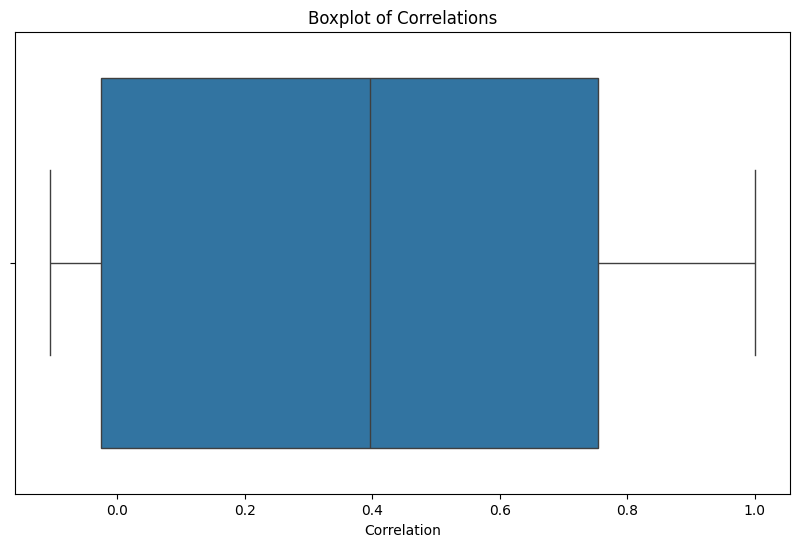

In [23]:
# Make boxplot of the correlations
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.boxplot(x=correlation_df['correlation'])
plt.title('Boxplot of Correlations')
plt.xlabel('Correlation')
plt.show()
